In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')

import pandas as pd
import numpy as np

from data_loader import DataLoader
from visualizer import TopicVisualizer
from preprocessor import IndonesianTextPreprocessor
from topic_model import TopicModeler

import yaml
import logging
from datetime import datetime

logging.basicConfig(
    level=logging.INFO,
    format='%(asctimes)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("All imports successful!")
print(f"Current working directory: ", {os.getcwd()})

All imports successful!
Current working directory:  {'/mnt/windows/titip/yas/code/Projects/Python/mbg-topic-modelling/notebooks'}


In [2]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(yaml.dump(config, default_flow_style=False))

os.makedirs(config['output']['figures_path'], exist_ok=True)
os.makedirs(config['output']['model_path'].rsplit('/', 1)[0], exist_ok=True)
os.makedirs(config['data']['processed_path'].rsplit('/', 1)[0], exist_ok=True)

Configuration loaded:
data:
  processed_path: ../data/processed/tweets_processed.csv
  raw_path: ../data/raw/tweets.csv
  text_column: text
model:
  calculate_probabilities: true
  embedding_model: paraphrase-multilingual-MiniLM-L12-v2
  min_topic_size: 10
  n_gram_range:
  - 1
  - 2
  name: bertopic
  nr_topics: auto
output:
  figures_path: ../results/figures/
  model_path: ../models/topic_model.pkl
  results_path: ../results/
preprocessing:
  language: indonesian
  max_length: 500
  min_length: 3
  remove_hashtags: false
  remove_mentions: true
  remove_numbers: true
  remove_urls: true



In [3]:
loader = DataLoader(
    file_path=config['data']['raw_path'],
    text_column=config['data']['text_column']
)

df_raw = loader.load_data()

loader.validate_data()

stats = loader.get_basic_stats()

print("\nDataset Statistics:")
for key, value in stats.items():
    print(f"    {key}:  {value}")

print("\nSample tweets:")
print(loader.sample_data(n=3)[config['data']['text_column']])

INFO:data_loader:Loading data from ../data/raw/tweets.csv
INFO:data_loader:Successfully loaded 54105 records!
INFO:data_loader:Data validation complete
INFO:data_loader:Dataset statistics: {'total_records': 54105, 'non_null_texts': 54105, 'avg_text_length': np.float64(153.06302559837354), 'median_text_length': np.float64(128.0), 'min_text_length': np.int64(3), 'max_text_length': np.int64(785)}



Dataset Statistics:
    total_records:  54105
    non_null_texts:  54105
    avg_text_length:  153.06302559837354
    median_text_length:  128.0
    min_text_length:  3
    max_text_length:  785

Sample tweets:
11537    Tidak heran jika target sasaran Program Makan ...
38024    PBNU - BGN Teken Kerja Sama Program Makan Berg...
12788    @democrazymedia Prabowo = Presiden BINGUNG: 1)...
Name: text, dtype: str


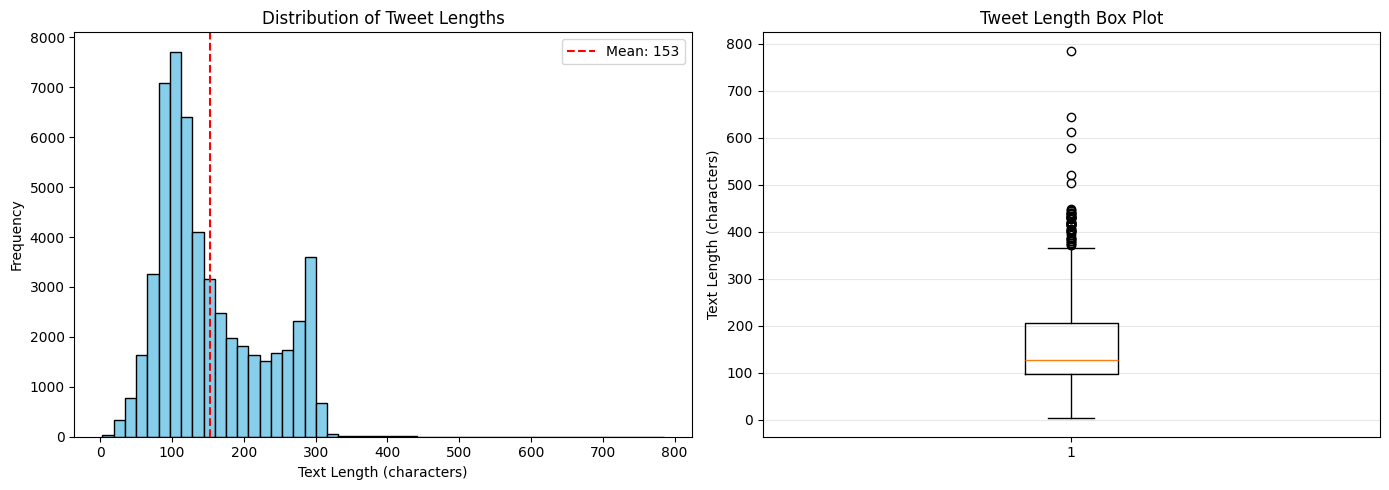


Text length statistics:
  Mean: 153.06
  Median: 128.00
  Std: 73.30
  Min: 3
  Max: 785


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

text_lengths = df_raw[config['data']['text_column']].str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Tweet Lengths')
axes[0].axvline(text_lengths.mean(), color='red', linestyle='--', 
                label=f'Mean: {text_lengths.mean():.0f}')
axes[0].legend()

axes[1].boxplot(text_lengths, vert=True)
axes[1].set_ylabel('Text Length (characters)')
axes[1].set_title('Tweet Length Box Plot')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nText length statistics:")
print(f"  Mean: {text_lengths.mean():.2f}")
print(f"  Median: {text_lengths.median():.2f}")
print(f"  Std: {text_lengths.std():.2f}")
print(f"  Min: {text_lengths.min()}")
print(f"  Max: {text_lengths.max()}")

In [5]:
preprocessor = IndonesianTextPreprocessor(
    remove_urls=config['preprocessing']['remove_urls'],
    remove_mentions=config['preprocessing']['remove_mentions'],
    remove_hashtags=config['preprocessing']['remove_hashtags'],
    remove_numbers=config['preprocessing']['remove_numbers'],
    min_length=config['preprocessing']['min_length'],
    max_length=config['preprocessing']['max_length'],
    use_stemming=True,  # Important for Indonesian
    use_stopword_removal=True  # Remove common words
)

print("✓ Preprocessor initialized")

INFO:preprocessor:Stemmer initialized
INFO:preprocessor:Stopword remover initialized


✓ Preprocessor initialized


In [6]:
sample_texts = df_raw[config['data']['text_column']].head(5).tolist()

print("PREPROCESSING TEST")
print("="*80)

for i, text in enumerate(sample_texts, 1):
    print(f"\nExample {i}:")
    print(f"Original: {text}")
    
    cleaned = preprocessor.clean_text(text)
    print(f"Cleaned: {cleaned}")
    
    processed = preprocessor.remove_stopwords_and_stem(cleaned)
    print(f"Processed: {processed}")
    print(f"Valid: {preprocessor.is_valid_text(processed)}")
    print("-"*80)

PREPROCESSING TEST

Example 1:
Original: @Batigoltaeng @AnakLolina2 Janji yg siap2 jadi omon omon. - Makan siang &gt
Cleaned: janji yg siap jadi omon omon makan siang gt
Processed: janji yg siap jadi omon omon makan siang gt
Valid: True
--------------------------------------------------------------------------------

Example 2:
Original: Ok gas ok gas makan siang gratis jadi makan bergizi berubah lagi sarapan gratis Itu kan yang kalian inginkan wahai 59% pemilih??!!
Cleaned: ok gas ok gas makan siang gratis jadi makan bergizi berubah lagi sarapan gratis itu kan yang kalian inginkan wahai pemilih
Processed: gas gas makan siang gratis jadi makan gizi ubah sarap gratis kan kalian ingin wahai pilih
Valid: True
--------------------------------------------------------------------------------

Example 3:
Original: Program Makan Bergizi Gratis: Menilai Kesesuaian dengan Prioritas Nasional https://t.co/TlDTRqNKiG
Cleaned: program makan bergizi gratis menilai kesesuaian dengan prioritas nasional

In [7]:
print("Starting full dataset preprocessing...")
print("This will take ~5-7 minutes. Please wait...")
print()

df_processed = preprocessor.preprocess(
    df_raw[config['data']['text_column']].tolist(),
    show_progress=True
)

df_processed['original_index'] = df_raw.index

print("\n" + "="*80)
print("PREPROCESSING RESULTS")
print("="*80)
print(f"Total texts processed: {len(df_processed)}")
print(f"Valid texts: {df_processed['is_valid'].sum()}")
print(f"Filtered out: {(~df_processed['is_valid']).sum()}")
print(f"Filter rate: {(~df_processed['is_valid']).sum() / len(df_processed) * 100:.2f}%")

df_processed.to_csv(config['data']['processed_path'], index=False)
print(f"\n✓ Processed data saved to {config['data']['processed_path']}")

INFO:preprocessor:Starting preprocessing of 54105 texts
INFO:preprocessor:Processed 0/54105 texts


Starting full dataset preprocessing...
This will take ~5-7 minutes. Please wait...



INFO:preprocessor:Processed 5000/54105 texts
INFO:preprocessor:Processed 10000/54105 texts
INFO:preprocessor:Processed 15000/54105 texts
INFO:preprocessor:Processed 20000/54105 texts
INFO:preprocessor:Processed 25000/54105 texts
INFO:preprocessor:Processed 30000/54105 texts
INFO:preprocessor:Processed 35000/54105 texts
INFO:preprocessor:Processed 40000/54105 texts
INFO:preprocessor:Processed 45000/54105 texts
INFO:preprocessor:Processed 50000/54105 texts
INFO:preprocessor:Preprocessing complete: 54099 valid texts, 6 filtered out



PREPROCESSING RESULTS
Total texts processed: 54105
Valid texts: 54099
Filtered out: 6
Filter rate: 0.01%

✓ Processed data saved to ../data/processed/tweets_processed.csv


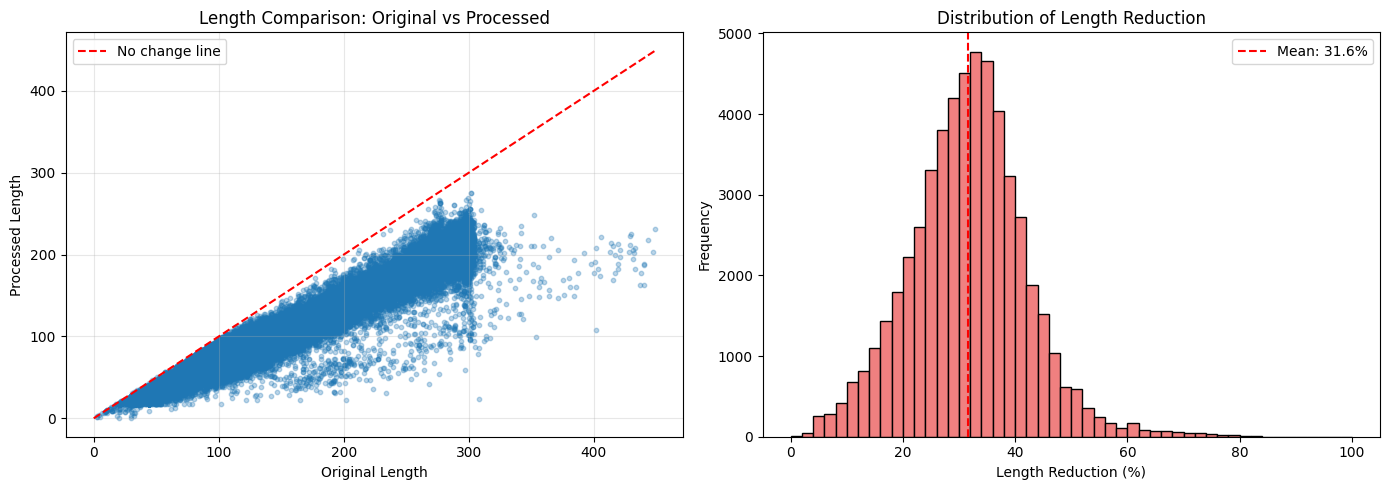

Average length reduction: 31.62%
Median length reduction: 31.76%


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

valid_df = df_processed[df_processed['is_valid']]

axes[0].scatter(valid_df['original_length'], valid_df['processed_length'], 
               alpha=0.3, s=10)
axes[0].plot([0, valid_df['original_length'].max()], 
            [0, valid_df['original_length'].max()], 
            'r--', label='No change line')
axes[0].set_xlabel('Original Length')
axes[0].set_ylabel('Processed Length')
axes[0].set_title('Length Comparison: Original vs Processed')
axes[0].legend()
axes[0].grid(alpha=0.3)

length_reduction = (valid_df['original_length'] - valid_df['processed_length']) / valid_df['original_length'] * 100
axes[1].hist(length_reduction, bins=50, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Length Reduction (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Length Reduction')
axes[1].axvline(length_reduction.mean(), color='red', linestyle='--',
               label=f'Mean: {length_reduction.mean():.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Average length reduction: {length_reduction.mean():.2f}%")
print(f"Median length reduction: {length_reduction.median():.2f}%")

In [9]:
documents = preprocessor.get_preprocessed_texts(df_processed)

print(f"Total documents for modeling: {len(documents)}")
print(f"\nFirst 3 processed documents:")
for i, doc in enumerate(documents[:3], 1):
    print(f"{i}. {doc}")

Total documents for modeling: 54099

First 3 processed documents:
1. janji yg siap jadi omon omon makan siang gt
2. gas gas makan siang gratis jadi makan gizi ubah sarap gratis kan kalian ingin wahai pilih
3. program makan gizi gratis nilai sesuai prioritas nasional


In [10]:
topic_model = TopicModeler(
    embedding_model=config['model']['embedding_model'],
    nr_topics=config['model']['nr_topics'] if config['model']['nr_topics'] != 'auto' else None,
    min_topic_size=config['model']['min_topic_size'],
    n_gram_range=tuple(config['model']['n_gram_range']),
    calculate_probabilities=config['model']['calculate_probabilities']
)

print("✓ Topic model initialized")
print("\nModel configuration:")
print(f"  Embedding model: {config['model']['embedding_model']}")
print(f"  Number of topics: {config['model']['nr_topics']}")
print(f"  Min topic size: {config['model']['min_topic_size']}")
print(f"  N-gram range: {config['model']['n_gram_range']}")

INFO:topic_model:TopicModeler initialized with model: paraphrase-multilingual-MiniLM-L12-v2


✓ Topic model initialized

Model configuration:
  Embedding model: paraphrase-multilingual-MiniLM-L12-v2
  Number of topics: auto
  Min topic size: 10
  N-gram range: [1, 2]


In [ ]:
print("="*80)
print("STARTING TOPIC MODEL TRAINING")
print("="*80)
print("This will take approximately 15-20 minutes.")
print("Please be patient and don't interrupt the process.")
print()

topic_model.train(documents)

print("\n" + "="*80)
print("TRAINING COMPLETE!")
print("="*80)

INFO:topic_model:Starting training to 54099 documents
INFO:topic_model:Creating embedding model...
INFO:topic_model:Loading embedding model: paraphrase-multilingual-MiniLM-L12-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2


STARTING TOPIC MODEL TRAINING
This will take approximately 15-20 minutes.
Please be patient and don't interrupt the process.



INFO:httpx:HTTP Request: HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/modules.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/e8f8c211226b894fcb81acc59f3b34ba3efd5f42/modules.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/resolve-cache/models/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/e8f8c211226b894fcb81acc59f3b34ba3efd5f42/modules.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config_sentence_transformers.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/e8f8c211226b894fcb81acc59f3b34ba3efd5f42/config_sentence_transformers.json "

In [ ]:
topic_info = topic_model.get_topic_info()

print("TOPIC OVERVIEW")
print("="*80)
print(f"Total topics found: {len(topic_info[topic_info['Topic'] != -1])}")
print(f"Total documents: {len(documents)}")

outlier_info = topic_info[topic_info['Topic'] == -1]
if len(outlier_info) > 0:
    outlier_count = outlier_info['Count'].values[0]
    print(f"Outlier documents: {outlier_count} ({outlier_count/len(documents)*100:.2f}%)")

print("\nTop 10 Topics:")
print(topic_info[topic_info['Topic'] != -1].head(10)[['Topic', 'Count', 'Name']])

In [ ]:
def examine_topic(topic_id, n_words=15, n_docs=3):
    print(f"\n{'='*80}")
    print(f"TOPIC {topic_id}")
    print(f"{'='*80}")
    
    topic_row = topic_info[topic_info['Topic'] == topic_id].iloc[0]
    print(f"Documents: {topic_row['Count']}")
    print(f"Name: {topic_row['Name']}")
    
    print(f"\nTop {n_words} words:")
    words = topic_model.get_topic_words(topic_id, top_n=n_words)
    for i, (word, score) in enumerate(words, 1):
        print(f"  {i:2d}. {word:20s} (score: {score:.4f})")
    
    print(f"\nExample documents:")
    doc_topics = topic_model.get_document_topics(documents)
    topic_docs = doc_topics[doc_topics['Topic'] == topic_id].head(n_docs)
    
    for i, (_, row) in enumerate(topic_docs.iterrows(), 1):
        print(f"\n  Document {i}:")
        print(f"  {row['Document']}")
        if row['Probability'] is not None:
            print(f"  (Probability: {row['Probability']:.3f})")

for topic_id in topic_info[topic_info['Topic'] != -1]['Topic'].head(3):
    examine_topic(topic_id)

In [ ]:
visualizer = TopicVisualizer(
    model=topic_model,
    output_dir=config['output']['figures_path']
)

print("✓ Visualizer initialized")
print(f"Figures will be saved to: {config['output']['figures_path']}")

In [ ]:
top_topics = topic_info[topic_info['Topic'] != -1]['Topic'].head(6).tolist()

visualizer.plot_multiple_wordclouds(
    topic_ids=top_topics,
    save=True,
    filename="wordclouds_top_topics.png"
)

In [ ]:
visualizer.plot_topic_similarity_heatmap(
    top_n=20,
    save=True,
    filename="topic_similarity.png"
)

In [ ]:
visualizer.plot_document_topic_distribution(
    documents=documents,
    sample_size=1000,
    save=True,
    filename="assignment_confidence.png"
)

In [ ]:
# target_topics = 20
# topic_model.reduce_topics(nr_topics=target_topics)
# print(f"Topics reduced to {target_topics}")

# topic_info = topic_model.get_topic_info()
# print(topic_info[topic_info['Topic'] != -1].head(10))

In [ ]:
visualizer.generate_topic_report(
    output_file="topic_modeling_report.txt"
)

print("✓ Report generated")

In [ ]:
topic_model.save_model(config['output']['model_path'])

print(f"✓ Model saved to {config['output']['model_path']}")
print("\nModel files:")
print(f"  - {config['output']['model_path']}")
print(f"  - {config['output']['model_path'].replace('.pkl', '_embeddings.pkl')}")

In [ ]:
results_df = pd.DataFrame({
    'document': documents,
    'topic': topic_model.topics,
    'probability': topic_model.probs if topic_model.probs is not None else [None] * len(documents)
})

results_df = results_df.merge(
    df_processed[df_processed['is_valid']][['original_text', 'original_index']],
    left_index=True,
    right_index=True,
    how='left'
)

topic_names = topic_info.set_index('Topic')['Name'].to_dict()
results_df['topic_name'] = results_df['topic'].map(topic_names)

output_path = config['output']['results_path'] + 'topic_assignments.csv'
results_df.to_csv(output_path, index=False)

print(f"✓ Results exported to {output_path}")
print(f"\nExported {len(results_df)} document-topic assignments")
print("\nSample results:")
print(results_df.head())

In [ ]:
print("="*80)
print("TOPIC MODELING SUMMARY")
print("="*80)

print(f"\nDataset:")
print(f"  Raw documents: {len(df_raw)}")
print(f"  After preprocessing: {len(documents)}")
print(f"  Filter rate: {(1 - len(documents)/len(df_raw))*100:.2f}%")

print(f"\nTopics:")
n_topics = len(topic_info[topic_info['Topic'] != -1])
print(f"  Total topics: {n_topics}")
print(f"  Average documents per topic: {len(documents)/n_topics:.0f}")

if -1 in topic_info['Topic'].values:
    outliers = topic_info[topic_info['Topic'] == -1]['Count'].values[0]
    print(f"  Outliers: {outliers} ({outliers/len(documents)*100:.2f}%)")

print(f"\nTop 5 topics:")
for _, row in topic_info[topic_info['Topic'] != -1].head(5).iterrows():
    print(f"  Topic {row['Topic']}: {row['Count']} docs - {row['Name'][:60]}")

print(f"\nModel configuration:")
print(f"  Embedding model: {config['model']['embedding_model']}")
print(f"  Min topic size: {config['model']['min_topic_size']}")

print(f"\nOutputs:")
print(f"  Model: {config['output']['model_path']}")
print(f"  Figures: {config['output']['figures_path']}")
print(f"  Results: {output_path}")

print("\n" + "="*80)
print("✓ TOPIC MODELING COMPLETE!")
print("="*80)